In [1]:
#read dfs# import packages
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
import sys 
from sklearn.model_selection import learning_curve
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [2]:
train_X=pd.read_csv("../input/vol3-kopya-no-scaling/reduced_train_X.csv")
train_y=pd.read_csv("../input/vol3-kopya-no-scaling/train_y.csv")
normalized_test_df=pd.read_csv("../input/vol3-kopya-no-scaling/reduced_test_X.csv")
df_test1=pd.read_csv("../input/vol3-kopya-no-scaling/df_test1.csv")

In [3]:
train_X=train_X.drop(columns=train_X.columns[0])
train_y=train_y.drop(columns=train_y.columns[0])
normalized_test_df=normalized_test_df.drop(columns=normalized_test_df.columns[0])
df_test1=df_test1.drop(columns=df_test1.columns[0])

In [4]:
train_y.isna().sum()

ISLEM_TUTARI_Y    0
dtype: int64

In [5]:
bin_dict = {'PESIN': 1, 'TAKSITLI': 0}
train_X['ISLEM_TURU'] = train_X['ISLEM_TURU'].map(bin_dict)
normalized_test_df['ISLEM_TURU'] = normalized_test_df['ISLEM_TURU'].map(bin_dict)

In [6]:
#drop yıl_ay
train_X=train_X.drop(columns=["YIL_AY"])
normalized_test_df=normalized_test_df.drop(columns=["YIL_AY"])

In [7]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3526227 entries, 0 to 3526226
Data columns (total 28 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   ISLEM_ADEDI                        float64
 1   ISLEM_TURU                         int64  
 2   customer_id                        int64  
 3   sector_id                          int64  
 4   cit_bin                            float64
 5   islem_ortalamasi_per_sek_cust_tur  float64
 6   adet_per_cust                      float64
 7   tutar_per_cust                     float64
 8   islem_ort_per_cust                 float64
 9   adet_per_sek                       float64
 10  tutar_per_sek                      float64
 11  islem_ort_per_sek                  float64
 12  month                              object 
 13  season                             object 
 14  adet_per_month                     float64
 15  tutar_per_month                    float64
 16  islem_ort_per_mont

In [8]:
df = pd.concat([train_X, normalized_test_df], axis=0, sort=False)

In [9]:
df = pd.get_dummies(data=df, columns=['sector_id',"cit_bin","month","season"])

In [10]:
train_X = df[:len(train_X)]
normalized_test_df = df[len(train_X):]

In [11]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3526227 entries, 0 to 3526226
Columns: 103 entries, ISLEM_ADEDI to season_yaz
dtypes: float64(22), int64(2), uint8(79)
memory usage: 938.2 MB


In [12]:
# cross-validation with 5 splits

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

#Importing XGBM Classifier 
from xgboost import XGBRegressor

#creating an extreme Gradient boosting instance
xgb = XGBRegressor(
                   #early_stopping_rounds=100,
                   random_state=0, 
                   tree_method='gpu_hist', 
                   verbosity=0
                )

# parameters 
parameters_overfit = {
                "n_estimators": [100, 300, 500],
                "max_depth": [10, 12, 16],
                "subsample": [0.4, 0.5, 0.7],
                "reg_lambda":[1, 5, 10],
                "colsample_bytree": [0.4, 0.6, 1],
                "max_bin":[32, 64,128],
                'max_leaves': [15, 31, 63],
                "min_child_weight":[1,5,10],
                
}
# parameters 
parameters = {
                "n_estimators": [100, 300, 500],
                "max_depth": [4, 5, 7],
                "subsample": [0.4, 0.5, 0.7],
                "reg_lambda":[1, 5, 10],
                "reg_alpha": [1, 5, 10],
                "colsample_bytree": [0.4, 0.5, 0.7],
                "max_bin":[32, 64,128],
                'max_leaves': [15, 31, 63],
                "min_child_weight":[1,5,10],
                
}

xgb_overfit = XGBRegressor(
                        random_state=0, 
                        tree_method='gpu_hist', 
                        nthread=-1,
                        verbosity=1,
                        n_estimators=1000,
                        max_depth=16,
                        subsample=1,
                        reg_lambda=1,
                        colsample_bytree=0.4,
                        max_bin=128,
                        max_leaves=255,
                        min_child_weight=1,
                        learning_rate=0.001,
                       )

In [13]:
# grid search for parameters
grid = RandomizedSearchCV(estimator=xgb, param_distributions=parameters, cv=cv, n_iter=100)
grid.fit(train_X, train_y)

# print best scores
print("The best parameters are %s with a score of %0.4f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'subsample': 0.7, 'reg_lambda': 5, 'reg_alpha': 5, 'n_estimators': 500, 'min_child_weight': 1, 'max_leaves': 63, 'max_depth': 7, 'max_bin': 128, 'colsample_bytree': 0.7} with a score of 0.6710


In [14]:
# extend n_estimators to 1000
best_params_dict=grid.best_estimator_.get_params()
best_params_dict["n_estimators"]=1000
extented_xgb = XGBRegressor().set_params(**best_params_dict)
extented_xgb.fit(train_X, train_y)

# prediction results
y_pred = extented_xgb.predict(normalized_test_df)

In [15]:
len(np.unique(y_pred))

213690

(array([1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00,
        3.00000e+00, 7.10000e+01, 2.15811e+05, 2.45200e+03, 6.24000e+02,
        2.76000e+02, 1.50000e+02, 8.70000e+01, 4.10000e+01, 3.00000e+01,
        3.00000e+01, 1.30000e+01, 1.50000e+01, 6.00000e+00, 9.00000e+00,
        6.00000e+00, 3.00000e+00, 2.00000e+00, 4.00000e+00, 3.00000e+00,
        2.00000e+00, 3.00000e+00, 3.00000e+00, 2.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00, 2.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00

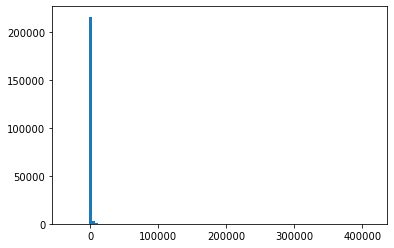

In [16]:
plt.hist(y_pred, bins=100)

In [17]:
np.sum(y_pred<=0)

2926

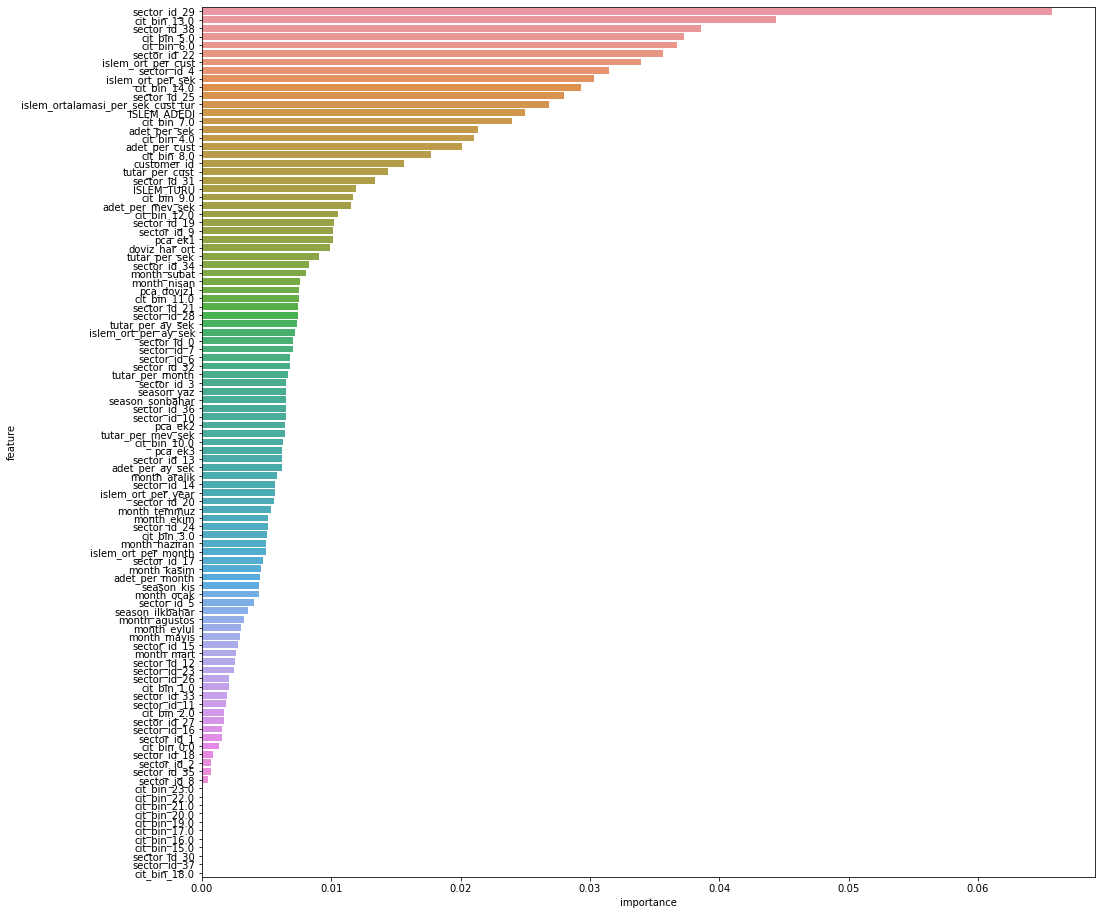

In [18]:
importance_df=pd.DataFrame(zip(normalized_test_df.columns.tolist(),extented_xgb.feature_importances_),columns=["feature","importance"])

import seaborn as sns
plt.figure(figsize=(16, 16))
sns.barplot(data=importance_df.sort_values(by='importance', ascending=False), x='importance', y='feature')

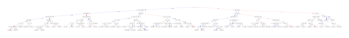

In [19]:
from xgboost import plot_tree
plot_tree(extented_xgb, num_trees=0)

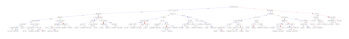

In [20]:
plot_tree(extented_xgb, num_trees=1)

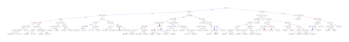

In [21]:
plot_tree(extented_xgb, num_trees=50)

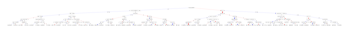

In [22]:
plot_tree(extented_xgb, num_trees=100)

In [23]:
# prediction results
pred_df=pd.DataFrame(zip(df_test1['sector_id'], y_pred), columns=['sector_id', 'predictions'])


In [24]:
submission_dff=pred_df.groupby('sector_id').sum()
ss=submission_dff.reset_index()

In [25]:
ss=ss.rename(columns={"sector_id": "Sektor_Id", "predictions": "Expected"})

In [26]:
ss.to_csv('out_random_search_xgboost.csv',index=False)
pred_df.to_csv('pred_df_random_search_xg', index=False)